In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# 1. Khai báo thư viện

In [2]:
from IPython.display import display, FileLink
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras import utils, layers, backend as K, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, TensorBoard

import tensorflow as tf
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

from IPython.display import FileLink
from IPython import display
import pandas as pd

from sklearn.metrics import classification_report
import cv2

from PIL import Image
import os
import shutil
from pathlib import Path

import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

import random
import tensorboard
from datetime import datetime
from packaging import version
import copy
# import visualkeras
from PIL import Image

import shutil

In [3]:
#Khai báo thư viện
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Training configurations
SEED_VALUE = 15
BATCH_SIZE = 32
N_EPOCH = 50
N_CLASSES = 6
VERBOSE = 1

# Original dimensions - 400 x 400
IMG_ROWS = 224
IMG_COLS = 224
IMG_CHANNELS = 3



In [5]:
# Seeding everything
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.compat.v1.set_random_seed(SEED_VALUE)

In [6]:

cur_dir = '/content/drive/MyDrive/Gr3_Fabric_Classification'
os.chdir(cur_dir)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/MyDrive/Gr3_Fabric_Classification


In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/Gr3_Fabric_Classification/preprocessing/train.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Gr3_Fabric_Classification/preprocessing/validation.csv')

In [9]:
train_df

,Filepath,Label
0,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
1,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
2,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
3,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
4,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
...,...,...
9025,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton
9026,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Wool
9027,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Polyester
9028,/content/drive/MyDrive/Gr3_Fabric_Classificati...,Cotton


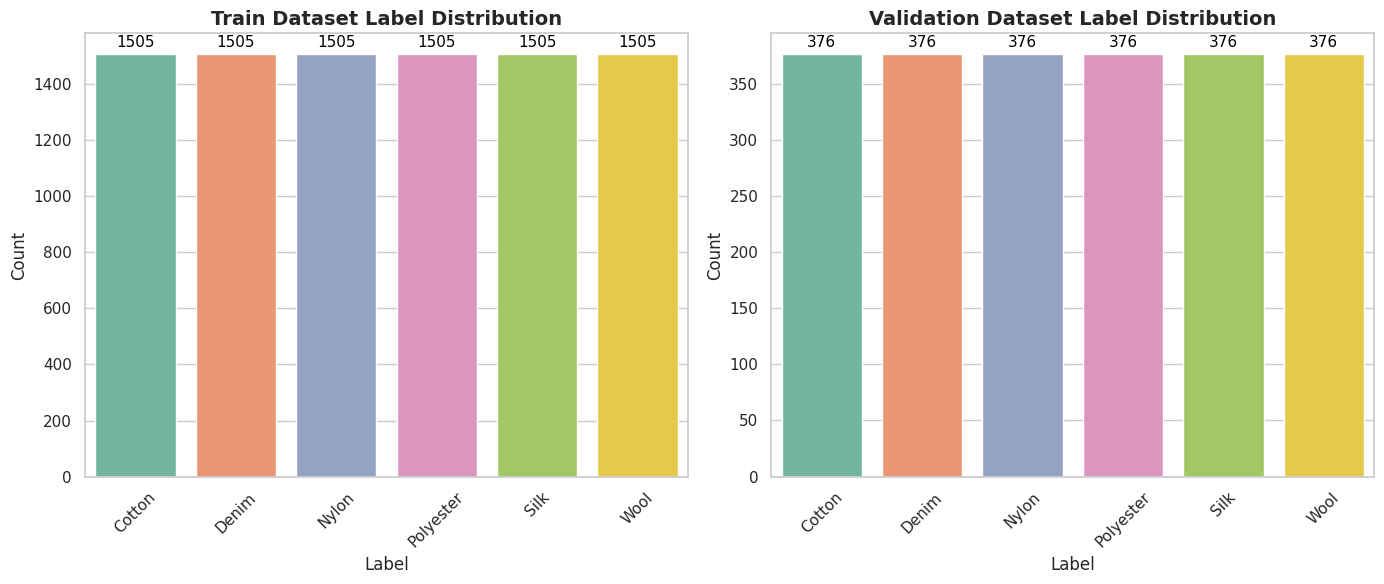

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Chuyển đổi cột Label thành Categorical mà không có thứ tự cụ thể
train_df['Label'] = pd.Categorical(train_df['Label'])
validation_df['Label'] = pd.Categorical(validation_df['Label'])  # Bỏ qua categories và ordered

# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Adjust color palette to match the number of unique labels
palette = sns.color_palette("Set2", n_colors=train_df['Label'].nunique())

plt.figure(figsize=(14, 6))

# Plot for train_df
plt.subplot(1, 2, 1)
train_ax = sns.countplot(x='Label', data=train_df, palette=palette, hue='Label', dodge=False, legend=False)
plt.title('Train Dataset Label Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Annotate counts on the bars for train_df
for p in train_ax.patches:
    train_ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                      textcoords='offset points')

# Plot for validation_df
plt.subplot(1, 2, 2)
val_ax = sns.countplot(x='Label', data=validation_df, palette=palette, hue='Label', dodge=False, legend=False)
plt.title('Validation Dataset Label Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Annotate counts on the bars for validation_df
for p in val_ax.patches:
    val_ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
train_datagenerator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

training_data = train_datagenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS),  # downsampling the images
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    rescale=1.0/255,
    shuffle=True,
    seed=SEED_VALUE,
)


Found 9030 validated image filenames belonging to 6 classes.


In [12]:
validation_datagenerator =  ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

validation_data = validation_datagenerator.flow_from_dataframe(
    dataframe=validation_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(IMG_ROWS, IMG_COLS), # downsampling the images
    interpolation='bicubic',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    rescale=1.0/255,
    shuffle=True,
    seed=SEED_VALUE
)

Found 2256 validated image filenames belonging to 6 classes.


# Model Creation

In [13]:
# Load the pretrained ResNet50 model
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freezing the layers
pretrained_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

def build_model():
    # Lấy đầu vào từ pretrained model
    inputs = pretrained_model.input

    # Lấy đầu ra từ pretrained model
    x = pretrained_model.output

    # Thêm Global Average Pooling
    # x = GlobalAveragePooling2D()(x)

    # Dense Layer 1
    x = BatchNormalization(axis=-1)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Dense Layer 2
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(N_CLASSES, activation='softmax')(x)

    # Tạo mô hình
    model = keras.Model(inputs=inputs, outputs=outputs)

    # In ra kiến trúc của model
    model.summary()

    return model

# Gọi hàm build_model và in ra kiến trúc
model = build_model()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,779,910 (94.53 MB)

 Trainable params: 1,187,078 (4.53 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [ ]:
# prompt: lưu các đặc trưng được trích xuất từ model vào /content/drive/MyDrive/Gr3_Fabric_Classification/data/image_extraction

import numpy as np

# Assuming you have your model and data loaded as 'model' and 'training_data'
# Also, assuming you want to extract features from the layer before the output layer.
# If you want features from a different layer, you'll need to modify the layer name accordingly.

# Get the output of the layer before the output layer
layer_name = 'dense_1'  # Replace with the actual layer name
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

# Extract features for the training data
features = intermediate_layer_model.predict(training_data)

# Save the extracted features to a directory
output_dir = '/content/drive/MyDrive/Gr3_Fabric_Classification/data/image_extraction'
os.makedirs(output_dir, exist_ok=True)

for i in range(len(features)):
  feature_filename = os.path.join(output_dir, f"feature_{i}.npy")
  np.save(feature_filename, features[i])

In [15]:
import numpy as np
from keras.optimizers import Adam  # Import optimizer Adam from Keras
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight  # Thêm thư viện class_weight
import tensorflow as tf

# Khai báo learning rate, loss function, và model metric
loss = 'categorical_crossentropy'
learning_rate = 0.0001

# Sử dụng optimizer Adam và learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Tiến hành huấn luyện mô hình
batch_size = 32
epochs = 10

starting_time = time.time()

# Tạo callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(training_data,
                    validation_data=validation_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stopping])  # Thêm early_stopping ở đây

print('> training time is %.4f minutes' % ((time.time() - starting_time) / 60))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


283/283 ━━━━━━━━━━━━━━━━━━━━ 7395s 26s/step - accuracy: 0.3819 - loss: 1.7933 - val_accuracy: 0.6334 - val_loss: 1.0025
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 135s 466ms/step - accuracy: 0.6807 - loss: 0.8732 - val_accuracy: 0.6857 - val_loss: 0.9090
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 137s 472ms/step - accuracy: 0.7520 - loss: 0.6853 - val_accuracy: 0.7035 - val_loss: 0.9350
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 133s 462ms/step - accuracy: 0.7892 - loss: 0.5705 - val_accuracy: 0.7256 - val_loss: 0.9439
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 133s 460ms/step - accuracy: 0.8140 - loss: 0.5003 - val_accuracy: 0.7318 - val_loss: 0.9081
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 134s 464ms/step - accuracy: 0.8384 - loss: 0.4376 - val_accuracy: 0.7491 - val_loss: 0.8930
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 133s 460ms/step - accuracy: 0.8556 - loss: 0.4063 - val_accuracy: 0.7668 - val_loss: 0.8367
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 132s 458ms/step - accuracy: 0.8703 - loss: 0.346

In [16]:
# prompt: xuất ra model tensorflow

model.save(f"{cur_dir}/models/save_models/base_line_resnet50.h5")


In [37]:
import numpy as np

# Tạo một model mới từ mô hình đã huấn luyện với đầu ra là lớp Dense cuối cùng trước lớp softmax
feature_extractor = keras.Model(inputs=model.input, outputs=model.layers[-3].output)  # Lớp -3 vì output softmax là lớp -1, lớp trước là Dropout -2

# Trích xuất đặc trưng từ tập dữ liệu huấn luyện và kiểm tra
train_features = feature_extractor.predict(training_data)
val_features = feature_extractor.predict(validation_data)

# Lấy nhãn từ dữ liệu huấn luyện và kiểm tra
train_labels = np.array(training_data.labels)
val_labels = np.array(validation_data.labels)
# Lưu đặc trưng và nhãn vào file
np.save(f'{cur_dir}/data/image_extraction/resnet50_feature_extraction/train_features.npy', train_features)
np.save(f'{cur_dir}/data/image_extraction/resnet50_feature_extraction/val_features.npy', val_features)

np.save(f'{cur_dir}/data/image_extraction/resnet50_feature_extraction/train_labels.npy', train_labels)
np.save(f'{cur_dir}/data/image_extraction/resnet50_feature_extraction/val_labels.npy', val_labels)

# Kiểm tra kích thước đặc trưng đã trích xuất
print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")


283/283 ━━━━━━━━━━━━━━━━━━━━ 110s 377ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 384ms/step
Train features shape: (9030, 256)
Validation features shape: (2256, 256)
Train labels shape: (9030,)
Validation labels shape: (2256,)


# Đánh giá mô hình

## Đánh giá trên tập validation

In [23]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_data)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 370ms/step - accuracy: 0.7567 - loss: 0.8261
Validation Loss: 0.8078
Validation Accuracy: 0.7686


In [24]:
# Make predictions on the validation data
y_pred = model.predict(validation_data)
y_pred_classes = np.argmax(y_pred, axis=1)

71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 362ms/step


In [25]:
y_true = validation_data.labels if hasattr(validation_data, 'labels') else np.concatenate([y for _, y in validation_data], axis=0)


In [26]:
print(classification_report(y_true, y_pred_classes))


              precision    recall  f1-score   support

           0       0.19      0.20      0.19       376
           1       0.15      0.11      0.13       376
           2       0.15      0.19      0.17       376
           3       0.16      0.16      0.16       376
           4       0.21      0.14      0.17       376
           5       0.17      0.20      0.18       376

    accuracy                           0.17      2256
   macro avg       0.17      0.17      0.17      2256
weighted avg       0.17      0.17      0.17      2256



In [27]:
# Calculate AUC for multi-class classification (One-hot encode y_true)
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(validation_data.class_indices))
auc_score = roc_auc_score(y_true_one_hot, y_pred, multi_class="ovr")
print(f"Validation AUC: {auc_score:.4f}")

Validation AUC: 0.4989


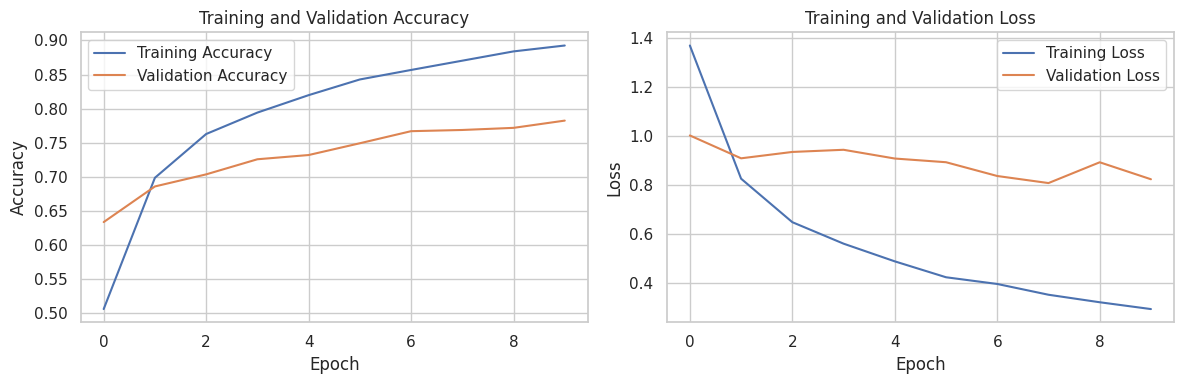

In [28]:
# Plot the training and validation accuracy and loss
if 'history' in globals():  # Check if the variable 'history' exists
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

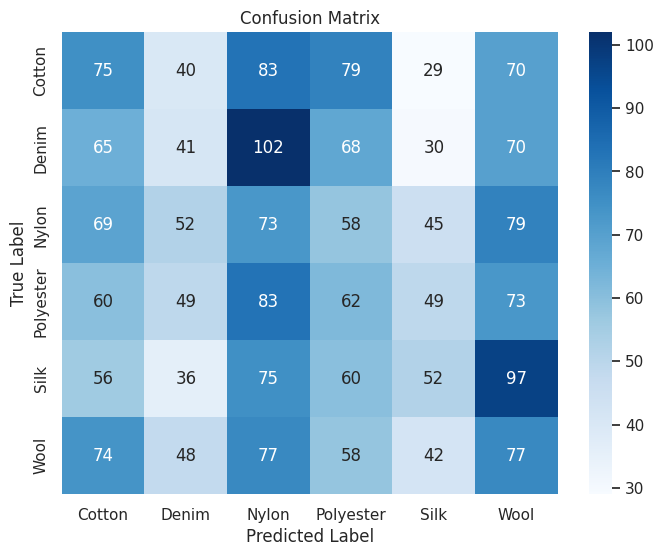

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_data.class_indices.keys(),
            yticklabels=validation_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - accuracy: 0.7719 - loss: 0.8272
Validation Loss: 0.8078
Validation Accuracy: 0.7686
71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step
              precision    recall  f1-score   support

           0       0.16      0.17      0.16       376
           1       0.12      0.09      0.10       376
           2       0.17      0.23      0.20       376
           3       0.16      0.16      0.16       376
           4       0.17      0.11      0.13       376
           5       0.15      0.19      0.17       376

    accuracy                           0.16      2256
   macro avg       0.15      0.16      0.15      2256
weighted avg       0.15      0.16      0.15      2256

Validation AUC: 0.4895


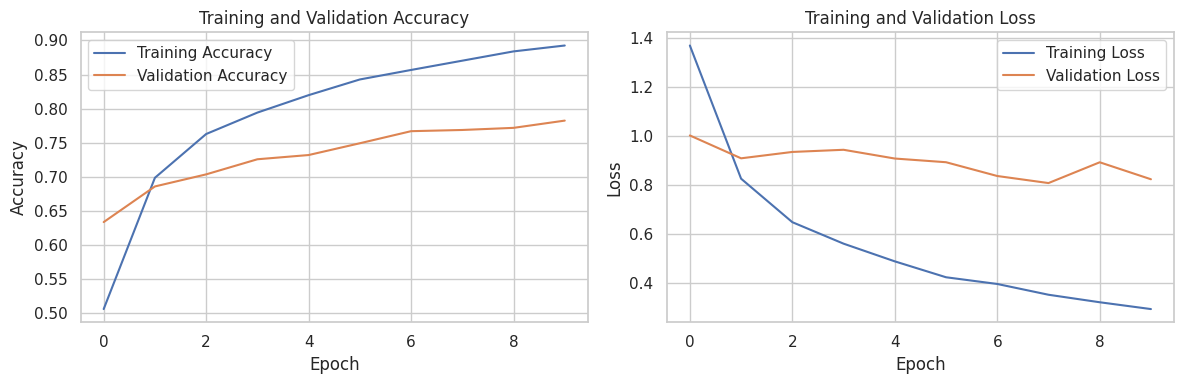

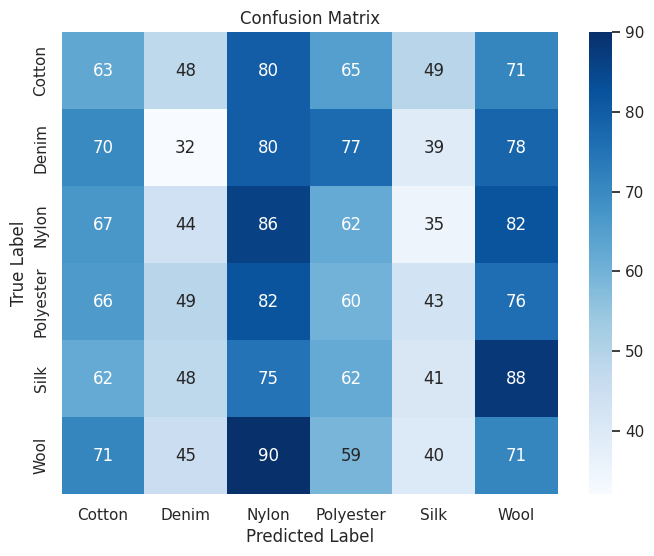

In [17]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_data)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Make predictions on the validation data
y_pred = model.predict(validation_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_data.labels

# Generate a classification report
print(classification_report(y_true, y_pred_classes))

# Calculate AUC for multi-class classification
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(validation_data.class_indices))
auc_score = roc_auc_score(y_true_one_hot, y_pred, multi_class="ovr")
print(f"Validation AUC: {auc_score:.4f}")

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_data.class_indices.keys(), yticklabels=validation_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [19]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_data)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 370ms/step - accuracy: 0.7567 - loss: 0.8728
Validation Loss: 0.8078
Validation Accuracy: 0.7686


In [20]:
# Make predictions on the validation data
y_pred = model.predict(validation_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_data.labels

71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step


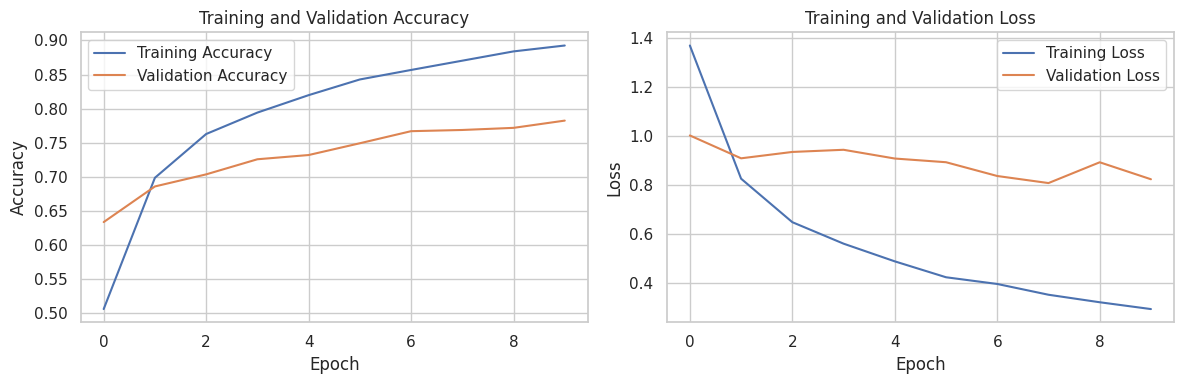

In [31]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Đánh giá mô hình trên tập test

In [ ]:
!jupyter nbconvert --to html '/content/drive/MyDrive/Gr3_Fabric_Classification/ipynb/resnet50.ipynb'
